In [1]:
import os
import wave
import shutil
import librosa
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd  # To play sound in the notebook
import seaborn as sns
from tqdm import tqdm_notebook
from scipy.io import wavfile

%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings("ignore", category=FutureWarning) 

### Loading data

In [236]:
data_dir = '../data/input/'
os.listdir(data_dir)

['train_curated',
 'train_curated.zip',
 'sample_submission.csv',
 'test.zip',
 'train_noisy.csv',
 'train_noisy',
 'train_curated.csv',
 'train_noisy.zip',
 'test']

In [237]:
train_curated = pd.read_csv(data_dir + 'train_curated.csv')
train_noisy = pd.read_csv(data_dir + 'train_noisy.csv')
test = pd.read_csv(data_dir + 'sample_submission.csv')

In [262]:
sample_wav_file = data_dir + 'train_curated/069d8df9.wav'   # Raindrop
ipd.Audio(sample_wav_file)

### row wave

In [263]:
rate, data = wavfile.read(sample_wav_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", len(data))
print("Duration = ", len(data) / rate)

Sampling (frame) rate =  44100
Total samples (frames) =  14464
Duration =  0.32798185941043084


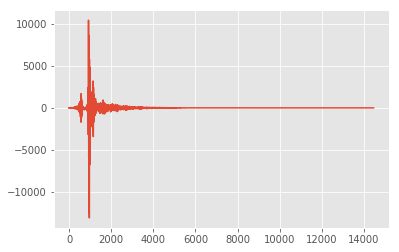

In [269]:
plt.plot(data, '-', );

### mel spectrogram

https://github.com/Cocoxili/DCASE2018Task2/blob/master/data_transform.py  
https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data

In [265]:
# === config ===
sampling_rate = 44100
duration = 2   # sec
hop_length = 347 * duration
n_mels = 128
n_fft = n_mels * 20
fmin = 20
fmax = sampling_rate // 2
padmode = 'constant'
samples = sampling_rate * duration
print(n_fft, hop_length)

2560 694


(128, 21)


Text(0.5,1,'accelerate')

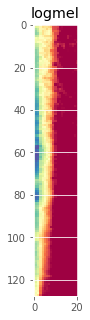

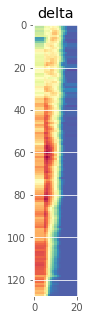

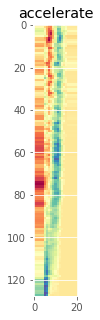

In [272]:
# === calc mel spec ===
def tsfm_logmel(data):
    melspec = librosa.feature.melspectrogram(
        data.astype(np.float32), sr=sampling_rate,
        n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax
    )
    logmel = librosa.core.power_to_db(melspec).astype(np.float32)
    delta = librosa.feature.delta(logmel).astype(np.float32)
    accelerate = librosa.feature.delta(logmel, order=2).astype(np.float32)

    return logmel, delta, accelerate

logmel, delta, accelerate = tsfm_logmel(data.astype(float))
print(logmel.shape)

# === plot ===
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(logmel, cmap='Spectral', interpolation='nearest')
plt.title("logmel")

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(delta, cmap='Spectral', interpolation='nearest')
plt.title("delta")

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(accelerate, cmap='Spectral', interpolation='nearest')
plt.title("accelerate")

In [255]:
def read_audio(y, samples, padmode, trim_long_data=False, padding_flg=False):
    # trim leading and trailing silence from an audio signal.
    if 0 < len(y):
        # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim,top_db=60 (default)
        
        print(len(y))
        n_thr_tmp = 18000
        if len(y) < n_thr_tmp:   # 6000 is extraordinary
            # delta features cant calcurated when logmel.shape[1] < 9
            padding = n_thr_tmp - len(y)
            offset = padding // 2
            y = np.pad(y, (offset, n_thr_tmp - len(y) - offset), 'constant')

    # make it unified length to conf.samples
    if len(y) > samples: # long enough
        if trim_long_data:
            y = y[0:0+samples]
    else:
        if padding_flg:
            # pad blank
            padding = samples - len(y)    # add padding at both ends
            offset = padding // 2
            y = np.pad(y, (offset, samples - len(y) - offset), padmode)

    return y

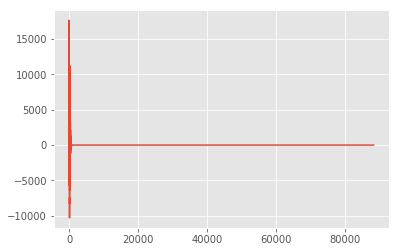

2048


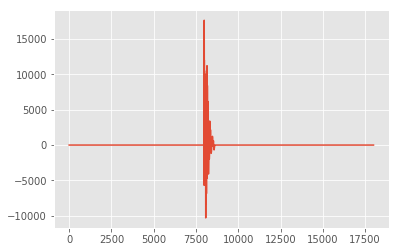

In [256]:
plt.plot(data, '-', )
plt.show()
trim_data = read_audio(data.astype(float), samples, padmode, False)
plt.plot(trim_data, '-', )
plt.show()

(128, 26)


Text(0.5,1,'accelerate')

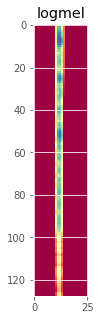

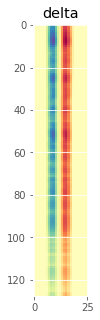

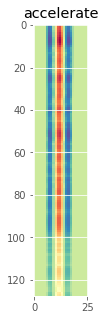

In [259]:
logmel, delta, accelerate = tsfm_logmel(trim_data)
print(logmel.shape)

# === plot ===
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(logmel, cmap='Spectral', interpolation='nearest')
plt.title("logmel")

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(delta, cmap='Spectral', interpolation='nearest')
plt.title("delta")

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(accelerate, cmap='Spectral', interpolation='nearest')
plt.title("accelerate")

### MFCC

https://github.com/Cocoxili/DCASE2018Task2/blob/master/data_transform.py

samples:  88200
(128, 899)


Text(0.5,1,'accelerate')

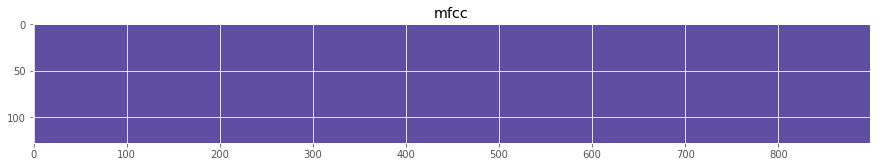

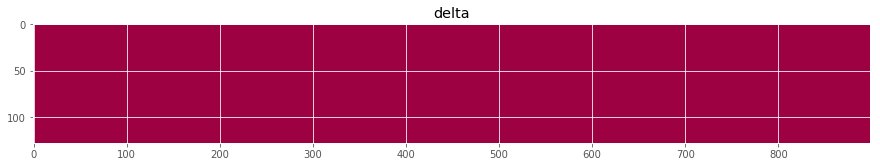

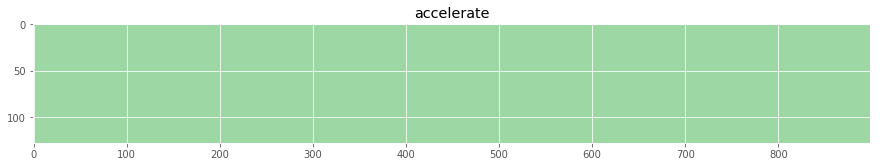

In [248]:
# === config ===
sampling_rate = 44100
duration = 2   # sec
hop_length = 347 * duration
n_mels = 128
n_fft = n_mels * 20
fmin = 20
fmax = sampling_rate // 2
samples = sampling_rate * duration
print("samples: ", samples)

# === calc mel spec ===
mfcc = librosa.feature.mfcc(
    data.astype(np.float32), sr=sampling_rate,
    n_fft=n_fft, hop_length=hop_length,
    n_mfcc=n_mels, fmin=fmin, fmax=fmax
)
mfcc = mfcc.astype(np.float32)
delta = librosa.feature.delta(mfcc)
accelerate = librosa.feature.delta(mfcc, order=2)
print(mfcc.shape)

# === plot ===
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(mfcc, cmap='Spectral', interpolation='nearest')
plt.title("mfcc")

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(delta, cmap='Spectral', interpolation='nearest')
plt.title("delta")

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(accelerate, cmap='Spectral', interpolation='nearest')
plt.title("accelerate")